In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0Warning: Failed to create the file data/animais.zip: No such file or directory
  0 11.6M    0  1177    0     0    161      0 21:02:55  0:00:07 21:02:48   270
curl: (23) Failure writing output to destination
unzip:  cannot find or open data/animais.zip, data/animais.zip.zip or data/animais.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
data_dir = '/content/drive/MyDrive/Tópicos_Contemporâneos/animals'
os.listdir(data_dir)

['train', 'val']

In [10]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

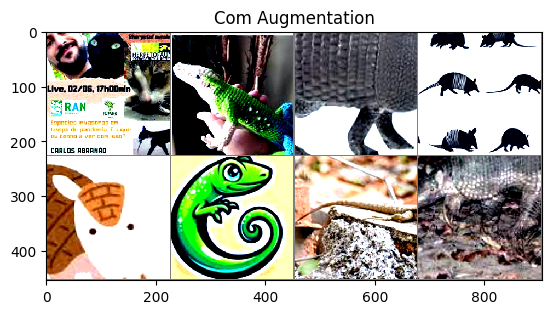

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


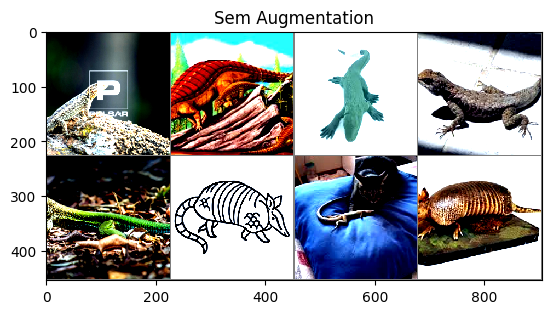

In [11]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if title is not None:
        plt.title(title)
    plt.show()

# Função para mostrar exemplos
def show_examples(loader, title):
    images, labels = next(iter(loader))
    images = images[:8]
    labels = labels[:8]
    imshow(torchvision.utils.make_grid(images, nrow=4), title)

# Mostrando exemplos com e sem data augmentation
show_examples(train_loader, title="Com Augmentation")
show_examples(val_loader, title="Sem Augmentation")

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 16 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [14]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [01:15<00:00,  5.82s/it]


Epoch 1, Train Loss: 0.694, Train Accuracy: 49.25%
Epoch 1, Val Loss: 0.685, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 2, Train Loss: 0.692, Train Accuracy: 51.75%
Epoch 2, Val Loss: 0.683, Val Accuracy: 60.66%


100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 3, Train Loss: 0.689, Train Accuracy: 56.75%
Epoch 3, Val Loss: 0.679, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


Epoch 4, Train Loss: 0.690, Train Accuracy: 58.25%
Epoch 4, Val Loss: 0.674, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 5, Train Loss: 0.686, Train Accuracy: 55.00%
Epoch 5, Val Loss: 0.668, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 6, Train Loss: 0.685, Train Accuracy: 59.50%
Epoch 6, Val Loss: 0.667, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 7, Train Loss: 0.680, Train Accuracy: 59.50%
Epoch 7, Val Loss: 0.655, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 8, Train Loss: 0.681, Train Accuracy: 60.50%
Epoch 8, Val Loss: 0.688, Val Accuracy: 53.28%


100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 9, Train Loss: 0.680, Train Accuracy: 57.25%
Epoch 9, Val Loss: 0.638, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 10, Train Loss: 0.661, Train Accuracy: 61.50%
Epoch 10, Val Loss: 0.595, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


Epoch 11, Train Loss: 0.673, Train Accuracy: 58.50%
Epoch 11, Val Loss: 0.565, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 12, Train Loss: 0.681, Train Accuracy: 59.25%
Epoch 12, Val Loss: 0.649, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:03<00:00,  3.65it/s]


Epoch 13, Train Loss: 0.670, Train Accuracy: 59.50%
Epoch 13, Val Loss: 0.627, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


Epoch 14, Train Loss: 0.648, Train Accuracy: 61.75%
Epoch 14, Val Loss: 0.572, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


Epoch 15, Train Loss: 0.622, Train Accuracy: 65.25%
Epoch 15, Val Loss: 0.612, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


Epoch 16, Train Loss: 0.677, Train Accuracy: 59.50%
Epoch 16, Val Loss: 0.632, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


Epoch 17, Train Loss: 0.650, Train Accuracy: 65.50%
Epoch 17, Val Loss: 0.572, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 18, Train Loss: 0.649, Train Accuracy: 63.50%
Epoch 18, Val Loss: 0.566, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 19, Train Loss: 0.637, Train Accuracy: 61.75%
Epoch 19, Val Loss: 0.568, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


Epoch 20, Train Loss: 0.641, Train Accuracy: 64.50%
Epoch 20, Val Loss: 0.611, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Epoch 21, Train Loss: 0.638, Train Accuracy: 65.00%
Epoch 21, Val Loss: 0.579, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


Epoch 22, Train Loss: 0.634, Train Accuracy: 66.75%
Epoch 22, Val Loss: 0.563, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


Epoch 23, Train Loss: 0.584, Train Accuracy: 69.50%
Epoch 23, Val Loss: 0.548, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:03<00:00,  3.69it/s]


Epoch 24, Train Loss: 0.599, Train Accuracy: 68.50%
Epoch 24, Val Loss: 0.519, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 25, Train Loss: 0.625, Train Accuracy: 68.00%
Epoch 25, Val Loss: 0.534, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Epoch 26, Train Loss: 0.595, Train Accuracy: 67.25%
Epoch 26, Val Loss: 0.554, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 27, Train Loss: 0.640, Train Accuracy: 64.00%
Epoch 27, Val Loss: 0.580, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 28, Train Loss: 0.610, Train Accuracy: 66.50%
Epoch 28, Val Loss: 0.542, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


Epoch 29, Train Loss: 0.630, Train Accuracy: 65.00%
Epoch 29, Val Loss: 0.553, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


Epoch 30, Train Loss: 0.647, Train Accuracy: 63.50%
Epoch 30, Val Loss: 0.579, Val Accuracy: 72.13%
Treinamento concluído


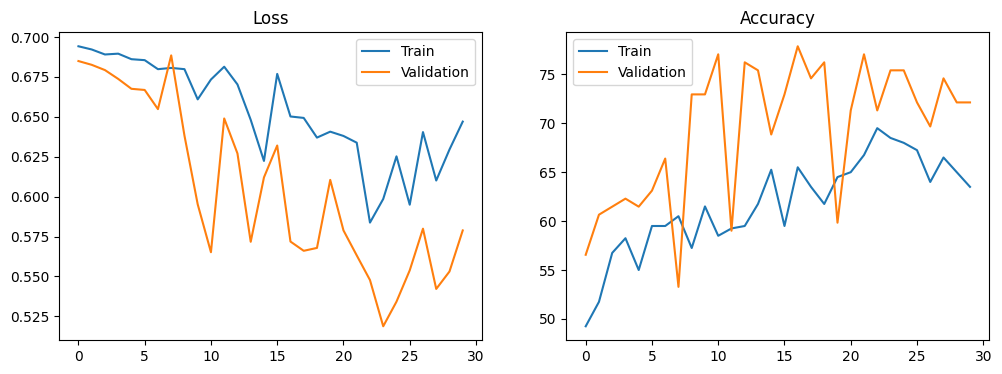

In [15]:
plot_history(history)

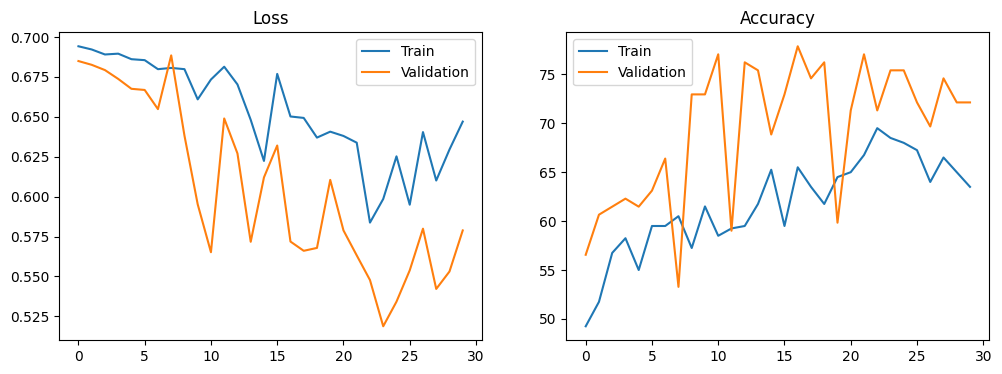

In [16]:
plot_history(history)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

In [17]:
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
